**This notebook aims to analyze housing price by using PySpark libraries.**

- Cleaning the data
- Exploratory data analysis
- Created new features
- Corrleation analysis
- Converted categorial data to numerical
- Linear regression for house price prediction
- Hyperparameter tuning

In [1]:
!pip install pyspark

     |████████████████████████████████| 281.3 MB 34 kB/s 
     |████████████████████████████████| 198 kB 67.1 MB/s 
  Created wheel for pyspark: filename=pyspark-3.2.0-py2.py3-none-any.whl size=281805912 sha256=64651494a95e6a1a6c1f97eb9660e1236da9c12dc63eac52935bb74cc04450b2
  Stored in directory: /root/.cache/pip/wheels/0b/de/d2/9be5d59d7331c6c2a7c1b6d1a4f463ce107332b1ecd4e80718
Successfully built pyspark


In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import seaborn as sns
from pyspark import SparkConf, SparkContext
from pyspark.sql import SparkSession, SQLContext
from pyspark.sql.types import *
import pyspark.sql.functions as F
from pyspark.sql.functions import udf, col

from pyspark.ml.regression import LinearRegression
from pyspark.mllib.evaluation import RegressionMetrics

from pyspark.ml.tuning import ParamGridBuilder, CrossValidator, CrossValidatorModel
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.evaluation import RegressionEvaluator

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/california-housing-prices/housing.csv


In [3]:
from pyspark.sql import SparkSession


In [4]:
spark  = SparkSession.builder.appName('Dataframe').getOrCreate()

Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
21/10/29 17:37:20 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [5]:
# Read the datasets
df_housing = spark.read.option('header', 'true').csv(os.path.join(dirname, 'housing.csv'), inferSchema = True)

In [6]:
#Showing first 20 rows
df_housing.head(3)

[Row(longitude=-122.23, latitude=37.88, housing_median_age=41.0, total_rooms=880.0, total_bedrooms=129.0, population=322.0, households=126.0, median_income=8.3252, median_house_value=452600.0, ocean_proximity='NEAR BAY'),
 Row(longitude=-122.22, latitude=37.86, housing_median_age=21.0, total_rooms=7099.0, total_bedrooms=1106.0, population=2401.0, households=1138.0, median_income=8.3014, median_house_value=358500.0, ocean_proximity='NEAR BAY'),
 Row(longitude=-122.24, latitude=37.85, housing_median_age=52.0, total_rooms=1467.0, total_bedrooms=190.0, population=496.0, households=177.0, median_income=7.2574, median_house_value=352100.0, ocean_proximity='NEAR BAY')]

In [7]:
#Check the schema
df_housing.printSchema()

root
 |-- longitude: double (nullable = true)
 |-- latitude: double (nullable = true)
 |-- housing_median_age: double (nullable = true)
 |-- total_rooms: double (nullable = true)
 |-- total_bedrooms: double (nullable = true)
 |-- population: double (nullable = true)
 |-- households: double (nullable = true)
 |-- median_income: double (nullable = true)
 |-- median_house_value: double (nullable = true)
 |-- ocean_proximity: string (nullable = true)



In [8]:
#print column names
df_housing.columns

['longitude',
 'latitude',
 'housing_median_age',
 'total_rooms',
 'total_bedrooms',
 'population',
 'households',
 'median_income',
 'median_house_value',
 'ocean_proximity']

In [9]:
#Checking data entries for each column
df_housing.select(['longitude',
 'latitude',
 'housing_median_age',
 'total_rooms',
 'total_bedrooms']).describe().show()

+-------+-------------------+-----------------+------------------+------------------+------------------+
|summary|          longitude|         latitude|housing_median_age|       total_rooms|    total_bedrooms|
+-------+-------------------+-----------------+------------------+------------------+------------------+
|  count|              20640|            20640|             20640|             20640|             20433|
|   mean|-119.56970445736148| 35.6318614341087|28.639486434108527|2635.7630813953488| 537.8705525375618|
| stddev|  2.003531723502584|2.135952397457101| 12.58555761211163|2181.6152515827944|421.38507007403115|
|    min|            -124.35|            32.54|               1.0|               2.0|               1.0|
|    max|            -114.31|            41.95|              52.0|           39320.0|            6445.0|
+-------+-------------------+-----------------+------------------+------------------+------------------+



In [10]:
df_housing.select(['population',
 'households',
 'median_income',
 'median_house_value',
 'ocean_proximity']).describe().show()

+-------+------------------+-----------------+------------------+------------------+---------------+
|summary|        population|       households|     median_income|median_house_value|ocean_proximity|
+-------+------------------+-----------------+------------------+------------------+---------------+
|  count|             20640|            20640|             20640|             20640|          20640|
|   mean|1425.4767441860465|499.5396802325581|3.8706710029070246|206855.81690891474|           null|
| stddev|  1132.46212176534|382.3297528316098| 1.899821717945263|115395.61587441359|           null|
|    min|               3.0|              1.0|            0.4999|           14999.0|      <1H OCEAN|
|    max|           35682.0|           6082.0|           15.0001|          500001.0|     NEAR OCEAN|
+-------+------------------+-----------------+------------------+------------------+---------------+



In [11]:
df_housing = df_housing.withColumnRenamed('median_house_value','price')

In [12]:
#Data imputation
df_housing.na.drop()

DataFrame[longitude: double, latitude: double, housing_median_age: double, total_rooms: double, total_bedrooms: double, population: double, households: double, median_income: double, price: double, ocean_proximity: string]

In [13]:
type(df_housing['price'])

pyspark.sql.column.Column

**Perliminary analysis**

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


+------------------+------------------+
|   skewness(price)|   kurtosis(price)|
+------------------+------------------+
|0.9776922140978437|0.3275001388119674|
+------------------+------------------+



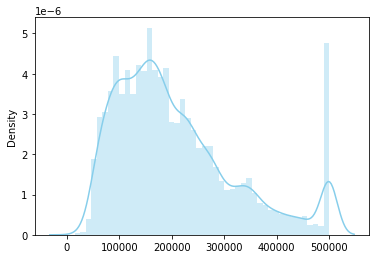

In [14]:
#Checking if the prices are normally distributed
sns.distplot(df_housing.select('price').toPandas(), color="skyblue")
df_housing.select(F.skewness('price'), F.kurtosis('price')).show()

In [15]:
#Housing prices greater than 500,000 (expensive houses)
print("No of houses: %i" % df_housing.select('price').count())
print("No of houses greater than $500000 are: %i" % df_housing.filter(df_housing["price"] > 500000).count())

No of houses: 20640
No of houses greater than $500000 are: 965


<AxesSubplot:ylabel='Count'>

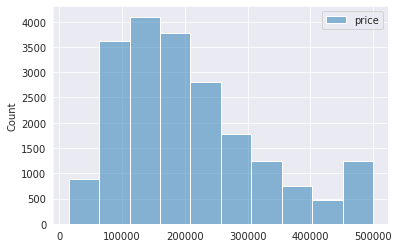

In [16]:
#Distribution of prices
sns.set_style("darkgrid")
sns.histplot(df_housing.select('price').toPandas(), bins = 10)

<AxesSubplot:xlabel='total_rooms', ylabel='avg(price)'>

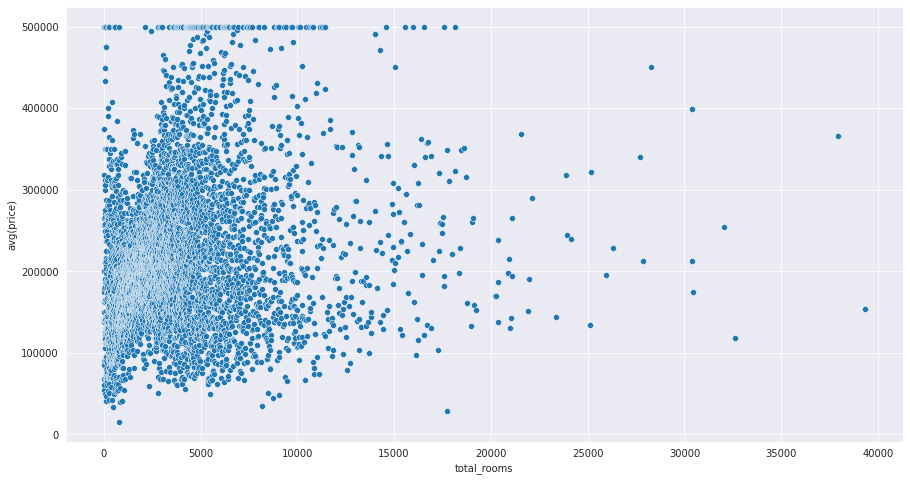

In [17]:
#Average price of house
import matplotlib.pyplot as plt
df1 = df_housing.groupby('total_rooms').avg().sort('total_rooms').select(['total_rooms','avg(price)'])
df_p = df1.toPandas()
plt.figure(figsize = (15, 8))
sns.scatterplot(x = df_p['total_rooms'], y = df_p['avg(price)'] )

In [18]:
#Adding a column of per-capita income to the dataframe

df_housing = df_housing.withColumn('per_capita_income', df_housing['median_income']*10000/df_housing['population'])

[(0.0, 500.0)]

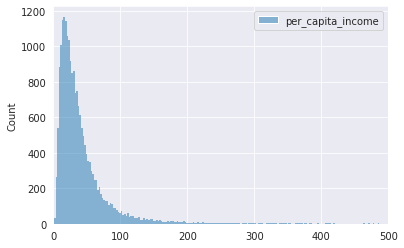

In [19]:
#per_capita_income distribution 
g = sns.histplot(df_housing.select('per_capita_income').toPandas())
g.set(xlim = (0, 500))


<AxesSubplot:xlabel='per_capita_income', ylabel='price'>

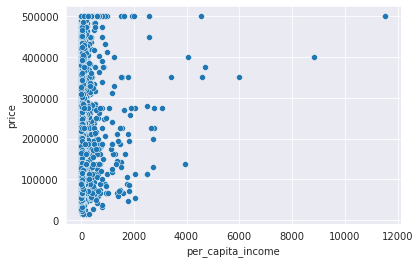

In [20]:
#Per-capita-income and prices of the home
df_p = df_housing.toPandas()
sns.scatterplot(x = df_p['per_capita_income'], y = df_p['price'])

#A lot of data has near $100 per-capita income - data is skewed towards zero. 

In [21]:
#Counting per capita that are less than $100
count_blocks = df_housing.filter('per_capita_income <  100').count()/df_housing.select('per_capita_income').count()*100
print("Percentage of blocks below $100 per capita: %2f" % count_blocks)

Percentage of blocks below $100 per capita: 92.596899


In [22]:
#Checking unique values in ocean_proximity
df_housing.select('ocean_proximity').distinct().show()

+---------------+
|ocean_proximity|
+---------------+
|         ISLAND|
|     NEAR OCEAN|
|       NEAR BAY|
|      <1H OCEAN|
|         INLAND|
+---------------+



<AxesSubplot:xlabel='ocean_proximity', ylabel='avg(median_income)'>

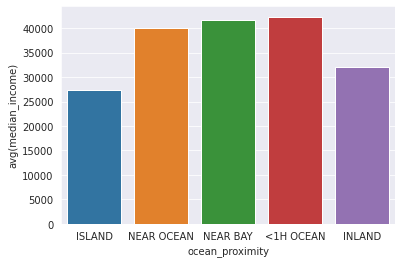

In [23]:
#Where does wealthy people live?
df_i = df_housing.groupby('ocean_proximity').agg({'median_income' : 'avg'})
df_p = df_i.toPandas()
sns.barplot(x = df_p['ocean_proximity'], y = df_p['avg(median_income)']*10000)

#Houses that are less than 1 hour to ocean where most wealthy people wants to live

In [24]:
#Label-encoding for the "ocean_proximity" column
from pyspark.ml.feature import StringIndexer
indexer = StringIndexer(inputCol="ocean_proximity", outputCol="ocean_proximity_index") 
df_housing = indexer.fit(df_housing).transform(df_housing)
df_housing = df_housing.drop('ocean_proximity')
df_housing.select('ocean_proximity_index').show(3)

+---------------------+
|ocean_proximity_index|
+---------------------+
|                  3.0|
|                  3.0|
|                  3.0|
+---------------------+
only showing top 3 rows



In [25]:
#Removing na values to ensure correlation method works properly
mean = df_housing.select(F.mean('total_bedrooms')).collect()[0][0]
df_housing = df_housing.na.fill({'total_bedrooms': mean})

In [26]:
#Checking if na values exist in 'total_bedrooms' columns
df_housing.filter(col('total_bedrooms').isNull()).show()

+---------+--------+------------------+-----------+--------------+----------+----------+-------------+-----+-----------------+---------------------+
|longitude|latitude|housing_median_age|total_rooms|total_bedrooms|population|households|median_income|price|per_capita_income|ocean_proximity_index|
+---------+--------+------------------+-----------+--------------+----------+----------+-------------+-----+-----------------+---------------------+
+---------+--------+------------------+-----------+--------------+----------+----------+-------------+-----+-----------------+---------------------+



/opt/conda/lib/python3.7/site-packages/pyspark/sql/context.py:127: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  FutureWarning


<AxesSubplot:>

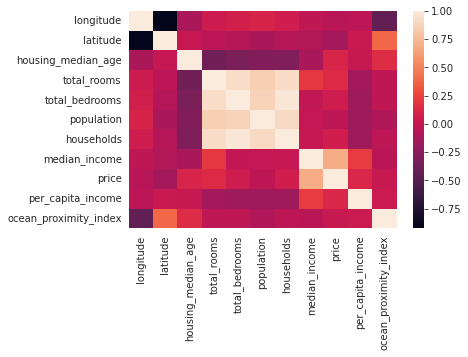

In [27]:
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler

# convert to vector column first
assembler = VectorAssembler(inputCols=df_housing.columns, outputCol="features")
df_vector = assembler.transform(df_housing).select("features")

# get correlation matrix
matrix = Correlation.corr(df_vector, 'features')
corrmatrix = matrix.collect()[0][0].toArray().tolist()

#Converst to pandas dataframe
df_corr = pd.DataFrame(corrmatrix, columns = df_housing.columns, index = df_housing.columns)

#plot correlation matrix by using seaborn
sns.heatmap(df_corr)


In [28]:
df_housing.columns

['longitude',
 'latitude',
 'housing_median_age',
 'total_rooms',
 'total_bedrooms',
 'population',
 'households',
 'median_income',
 'price',
 'per_capita_income',
 'ocean_proximity_index']

**Linear regression to predict prices**

In [29]:
#Drop non-correlated columns
df_model = df_housing.select(['housing_median_age','total_rooms', 'median_income','price'])
df_model.show(3)

+------------------+-----------+-------------+--------+
|housing_median_age|total_rooms|median_income|   price|
+------------------+-----------+-------------+--------+
|              41.0|      880.0|       8.3252|452600.0|
|              21.0|     7099.0|       8.3014|358500.0|
|              52.0|     1467.0|       7.2574|352100.0|
+------------------+-----------+-------------+--------+
only showing top 3 rows



/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


+----------------------------+----------------------------+
|skewness(housing_median_age)|kurtosis(housing_median_age)|
+----------------------------+----------------------------+
|        0.060326253016608676|         -0.8007255995445028|
+----------------------------+----------------------------+



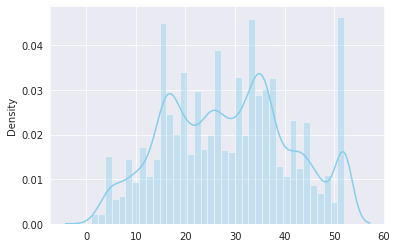

In [30]:
#Checking normal distribution of selected fetures
#housing_median_age

sns.distplot(df_housing.select('housing_median_age').toPandas(), color="skyblue")
df_housing.select(F.skewness('housing_median_age'), F.kurtosis('housing_median_age')).show()

#the housing_median_age is normally distributed

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


+---------------------+---------------------+
|skewness(total_rooms)|kurtosis(total_rooms)|
+---------------------+---------------------+
|    4.147042038773302|    32.62273207294906|
+---------------------+---------------------+



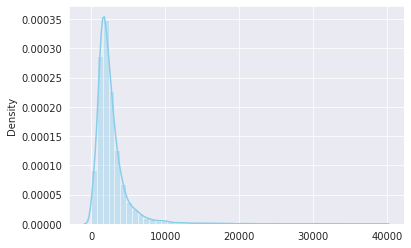

In [31]:
#Checking normal distribution of selected fetures
#total_rooms

sns.distplot(df_housing.select('total_rooms').toPandas(), color="skyblue")
df_housing.select(F.skewness('total_rooms'), F.kurtosis('total_rooms')).show()

#the total_rooms is not normally distributed

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


+-------------------------+-------------------------+
|skewness(total_rooms_log)|kurtosis(total_rooms_log)|
+-------------------------+-------------------------+
|      -1.0972584854175316|         5.25204961078785|
+-------------------------+-------------------------+



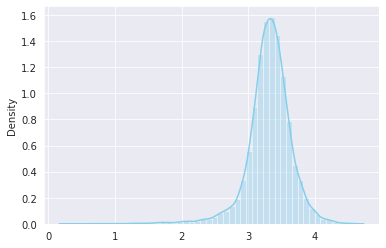

In [32]:
#Using lograthimic scale to normalize the data

df_model = df_model.withColumn("total_rooms_log", F.log10(col("total_rooms")))

sns.distplot(df_model.select('total_rooms_log').toPandas(), color="skyblue")
df_model.select(F.skewness('total_rooms_log'), F.kurtosis('total_rooms_log')).show()

#The distribution is now lograthmic distributed

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


+-----------------------+-----------------------+
|skewness(median_income)|kurtosis(median_income)|
+-----------------------+-----------------------+
|     1.6465370299001063|      4.951033760409806|
+-----------------------+-----------------------+



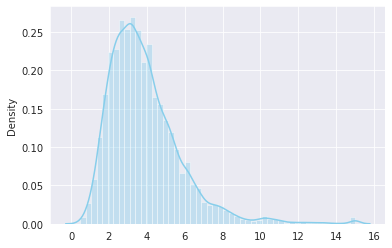

In [33]:
#Checking normal distribution of selected fetures
#median_income

sns.distplot(df_housing.select('median_income').toPandas(), color="skyblue")
df_housing.select(F.skewness('median_income'), F.kurtosis('median_income')).show()

#the median_income is normally distributed

In [34]:
#Assembling features
feature_assembly = VectorAssembler(inputCols = ['housing_median_age','total_rooms_log', 'median_income'], outputCol = 'features')
output = feature_assembly.transform(df_model)
output.show(3)

+------------------+-----------+-------------+--------+------------------+--------------------+
|housing_median_age|total_rooms|median_income|   price|   total_rooms_log|            features|
+------------------+-----------+-------------+--------+------------------+--------------------+
|              41.0|      880.0|       8.3252|452600.0|2.9444826721501687|[41.0,2.944482672...|
|              21.0|     7099.0|       8.3014|358500.0|3.8511971761741606|[21.0,3.851197176...|
|              52.0|     1467.0|       7.2574|352100.0| 3.166430113843283|[52.0,3.166430113...|
+------------------+-----------+-------------+--------+------------------+--------------------+
only showing top 3 rows



In [35]:
#Normalizing the features
from pyspark.ml.feature import StandardScaler

scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures",
                        withStd=True, withMean=False)

# Compute summary statistics by fitting the StandardScaler
scalerModel = scaler.fit(output)

# Normalize each feature to have unit standard deviation.
scaledOutput = scalerModel.transform(output)
scaledOutput.show(3)

+------------------+-----------+-------------+--------+------------------+--------------------+--------------------+
|housing_median_age|total_rooms|median_income|   price|   total_rooms_log|            features|      scaledFeatures|
+------------------+-----------+-------------+--------+------------------+--------------------+--------------------+
|              41.0|      880.0|       8.3252|452600.0|2.9444826721501687|[41.0,2.944482672...|[3.25770230160830...|
|              21.0|     7099.0|       8.3014|358500.0|3.8511971761741606|[21.0,3.851197176...|[1.66857922765303...|
|              52.0|     1467.0|       7.2574|352100.0| 3.166430113843283|[52.0,3.166430113...|[4.13171999228370...|
+------------------+-----------+-------------+--------+------------------+--------------------+--------------------+
only showing top 3 rows



In [36]:
#Selecting input and output column from output
df_model_final = scaledOutput.select(['price', 'scaledFeatures'])
df_model_final.show(3)

+--------+--------------------+
|   price|      scaledFeatures|
+--------+--------------------+
|452600.0|[3.25770230160830...|
|358500.0|[1.66857922765303...|
|352100.0|[4.13171999228370...|
+--------+--------------------+
only showing top 3 rows



In [37]:
from pyspark.ml.regression import LinearRegression 

#test train split
df_train, df_test = df_model_final.randomSplit([0.75, 0.25])
regressor = LinearRegression(featuresCol = 'scaledFeatures', labelCol = 'price')
regressor = regressor.fit(df_train)

21/10/29 17:38:14 WARN Instrumentation: [719c0de6] regParam is zero, which might cause numerical instability and overfitting.


In [38]:
#MSE for the train data

pred_results = regressor.evaluate(df_train)
print("The MSE for the model is: %2f"% pred_results.meanAbsoluteError)
print("The r2 for the model is: %2f"% pred_results.r2)

The MSE for the model is: 59847.644920
The r2 for the model is: 0.520369


In [39]:
#Checking train performance
pred_results = regressor.evaluate(df_test)
print("The MSE for the model is: %2f"% pred_results.meanAbsoluteError)
print("The r2 for the model is: %2f"% pred_results.r2)

The MSE for the model is: 60287.457176
The r2 for the model is: 0.499041
